## NLP - Sentiment Analysis Using LSTM 

In [1]:
# imports
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import wordcloud
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

### Data Pre-processing

In [2]:
# load the dataset
df = pd.read_csv('amazon_alexa.tsv',sep='\t', engine = 'python')

# check the column names + dimensions
print(df.columns)
print(df.shape)
df.groupby('rating')['rating'].nunique()

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')
(3150, 5)


rating
1    1
2    1
3    1
4    1
5    1
Name: rating, dtype: int64

For the purposes of this analysis, we will define positive sentiment as those review who have a score higher than 3 and negative sentiment as those with a review below 3. In bucketing reviews according to this definition, we will be able to build a model with an encoded binary target variable: 

In [3]:
# create a new variable based on overall ratings
def sentiments(dataframe):
  if dataframe['rating'] > 3.0:
    return 'Pos'
  elif dataframe['rating'] <= 3.0:
    return 'Neg'
df['overall_sentiment'] = df.apply(sentiments, axis=1)

# check for null values and subset data into the variables of interest
df2 = df[['verified_reviews','overall_sentiment']]
df2.isnull().sum()

verified_reviews     0
overall_sentiment    0
dtype: int64

We can now proceed to conduct some basic text pre-processing by removing digits, symbols, stopwords and any other special characters:

In [4]:
 # pre-processing
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence = str(sentence) # create a string
    sentence = sentence.lower() # lowercase
    cleanchar = re.compile('<.*?>') # remove special characters
    cleantxt = re.sub(cleanchar, '', sentence) 
    rem_numer = re.sub('[0-9]+', '', cleantxt) # remove numerical values
    tokenizer = RegexpTokenizer(r'\w+') # tokenize
    tokens = tokenizer.tokenize(rem_numer)  
    filt_words = [word for word in tokens if len(word) > 2 if not word in stopwords.words('english')] # remove stopwords
    stem_wrds=[stemmer.stem(word) for word in filt_words] # stemming
    lem_words=[lemmatizer.lemmatize(word) for word in stem_wrds] # lemmatize
    return " ".join(lem_words)

df2['verified_reviews'] = df2['verified_reviews'].map(lambda s:preprocess(s)) 

C:\Users\hedle\AppData\Local\Temp/ipykernel_23764/497306974.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['verified_reviews'] = df2['verified_reviews'].map(lambda s:preprocess(s))


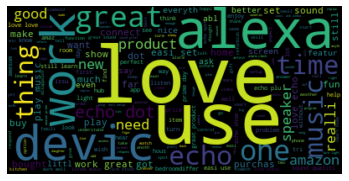

In [5]:
# visualize common words in reviews
comm_wrds=''
for i in df2.verified_reviews:
    i = str(i)
    toks = i.split()
    comm_wrds += " ".join(toks)+" "
wordcloud = wordcloud.WordCloud().generate(comm_wrds)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Model Development

In [6]:
# encode target variable
labl = LabelEncoder()
df2['overall_sentiment'] = labl.fit_transform(df2['overall_sentiment'])

# tokenize and convert reviews into numerical vectors
tok = Tokenizer(num_words = 500, split=' ') 
tok.fit_on_texts(df2['verified_reviews'].values)
X = tok.texts_to_sequences(df['verified_reviews'].values)
X = pad_sequences(X)

C:\Users\hedle\AppData\Local\Temp/ipykernel_23764/2860539510.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['overall_sentiment'] = labl.fit_transform(df2['overall_sentiment'])


The main hyperparameters defined above can be expressed as such:
1) *num_words* = refers to the number of words to keep based on the overall frequency of words
2) *split* = refers to the separator used for splitting said word
3) *pad_sequence* = function that converts a list of sequences into a 2D NumPy array

We can now proceed to building the LSTM model using the keras **sequential API** class by initializing the model, creating the relevant LSTM layers and compiling the model to generate predictions:

In [7]:
# define model architecture
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

# split into training and test sets
y = pd.get_dummies(df2['overall_sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 99)

# training
batch_size = 39
history = model.fit(X_train, y_train, epochs = 8, batch_size = batch_size, verbose = 'auto', validation_data=(X_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 120)          60000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 120, 120)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 2)                 354       
                                                                 
Total params: 269,442
Trainable params: 269,442
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/8
57/57 [==============================] - 50s 825ms/step - loss: 0.3914 - accuracy: 0.8667 - val_loss:

30/30 [==============================] - 3s 83ms/step - loss: 0.3295 - accuracy: 0.8847


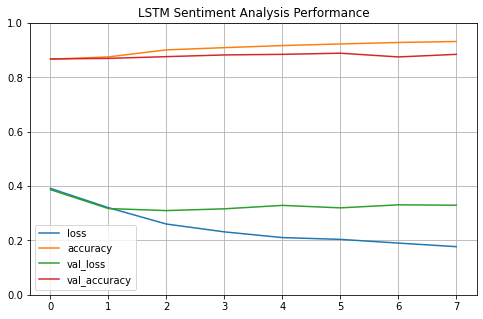

In [9]:
# evaluate performance
model.evaluate(X_test,y_test)

# plot the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.title("LSTM Sentiment Analysis Performance")
plt.show()

We have successfully built our LSTM model for classifying sentiments for Amazong Alexa product reviews based on the 'positive' and 'negative' categories for overall rating. The final model had an accuracy of **0.8847** but further model exploration could look at other hyperparameter finetuning methods to improve performance. 